<img src="https://i.ibb.co/TcVMz44/logo.jpg" alt="logo" border="0" width=200>

# Computational Astrophysics 2021
---
## Eduard Larrañaga

Observatorio Astronómico Nacional\
Facultad de Ciencias\
Universidad Nacional de Colombia


## N-Body Problem. Sagittarius A* and the S0-stars

### About this notebook

In this notebook we solve the equations of motion for the gravitational system composed by the SMBH Sagittarius A* and 13 of the S0-stars moving around it.

---

## The N-Body System

The equations of motion of N-bodies moving under their mutual gravitational interaction are given by $N$-vector differential equations of second order

\begin{equation}
m_i \ddot{\vec{x}}_i = - G m_i \sum_{j=1,i\ne j}^N \frac{m_j}{|\vec{x}_{ij}|^3} \vec{x}_{ij},
\end{equation}

where $\vec{x}_{ij} = \vec{x}_i - \vec{x}_j$ is the vector pointing from the particle $j$ to the the particle $i$. 

We can write this differential system as a set of $2N$-vector differential equations of first order,

\begin{align}
\begin{cases}
\frac{d \vec{x}_i}{dt} = &\vec{v}_i \\
\frac{d\vec{v}_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j}{|\vec{x}_{ij}|^3} \vec{x}_{ij}.
\end{cases}
\end{align}

These vector equations are written in terms of the cartesian components of the position $\vec{x} = (x,y,z)$ and the velocity $\vec{v} = (v^x, v^y, v^z)$ as the set

\begin{align}
\begin{cases}
\frac{d x_i}{dt} = &v^x_i \\
\frac{d y_i}{dt} = &v^y_i \\
\frac{d z_i}{dt} = &v^z_i \\
\frac{dv^x_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (x_i - x_j)}{r_{ij}^3} \\
\frac{dv^y_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (y_i - y_j)}{r_{ij}^3} \\
\frac{dv^z_i}{dt} = &- G \sum_{j=1,i\ne j}^N \frac{m_j (z_i - z_j)}{r_{ij}^3} 
\end{cases}
\end{align}

where $|\vec{x}_{ij}| = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2+ (z_i - z_j)^2} = r_{ij}$.


---
## Implementation of the Equations of Motion

An important consideration to take into account involves the big numbers involved in the problem such as the bodies' masses and the distances. It is convenient to use a system of units where

- The unit of mass is the Solar mass $M_{\odot}$
- The unit of distance is the Astronomical Unit (au)
- The unit of time is the year (yr)

Using this system, the Newtonian gravitational constant will have the value $G = 4\pi^2$.

In [1]:
path=''

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/AC/Colab Notebooks/12. The Galactic Center/'

import sys 
sys.path.append(path) # Append the path of the local modules

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3D
# %matplotlib notebook  # Makes interactive the 3D plot when running locally! 


# Relevant Constants in the units
# (years, AU, Solar_masses)
# Newtonian Gravitational Constant
G = 4.*np.pi**2

# Conversion factors
arcsec_in_au = 8000 # 1 arcsec in au

The ODEs system is implemented by defining the function 

In [4]:
def ODE(t0, q0):
    '''
    ------------------------------------------
    ODE(t,q0) 
    ------------------------------------------
    ODEs system for the motion of N-particles 
    
    Arguments:
    t0: time parameter (not necessary for 
        the Newtonian problem)
    q0: numpy array with the initial condition
        data:
        q0[0] = particle 1
        q0[1] = particle 2
        etc.
        q0[0] = [x0, y0, z0, vx0, vy0, vz0]
    mass: masses of the particles
    ------------------------------------------
    '''
    Q = np.zeros(q0.shape)
    Q[:,0:3] = q0[:,3:] #Assign initial value
    for i in range (0,N):
        Deltaxyz = q0[i,0:3] - q0[:,0:3]
        # Distance between particles
        r = np.sqrt(np.sum(Deltaxyz*Deltaxyz,axis=1))
        # To avoid divivision by zero in the self-force terms
        # The terms vanish due to the Delta term in the numerator!
        r[i] = 100 
        Q[i,3] = -G * np.sum(Deltaxyz[:,0] * mass/(r**3))
        Q[i,4] = -G * np.sum(Deltaxyz[:,1] * mass/(r**3))
        Q[i,5] = -G * np.sum(Deltaxyz[:,2] * mass/(r**3))
    return Q

## Conserved Energy

In order to ensure the integration porocedure, we will introduce the total energy of the N-Body system which is a conserved quantity,

\begin{equation}
E = \frac{1}{2} \sum_{i=1}^N m_i |\vec{v}_i|^2 -
 \frac{1}{2}G \sum_{i=1}^N \sum_{j=1,i\ne j}^N \frac{m_i m_j}{r_{ij}}
\end{equation}

In [5]:
def TotalEnergy(q0):
  '''
  Total Energy calculation
  '''
  (x,y,z,vx,vy,vz) = q0.transpose()
  v2 = vx**2+vy**2+vz**2
  Ekin = 0.5*np.sum(mass*v2)
  Egrav = 0.
  for i in range(0,N):
    deltax = x[i] - x
    deltay = y[i] - y
    deltaz = z[i] - z
    r = np.sqrt(deltax**2 + deltay**2 + deltaz**2)
    # To avoid divivision by zero and put the value of the term to zero!
    r[i] = 1e300 
    Egrav += - 0.5*G * mass[i] * np.sum(mass/r)
  return Ekin + Egrav

We will use a RK4 integrator to solve the problem.

In [6]:
def RK4(dt, t0, q0):
    '''
    ------------------------------------------
    RK4(h, t0, q0)
    ------------------------------------------
    4th Order Runge-Kutta method for solving 
    a system of ODEs.
    Arguments:
    ODE: function defining the system of ODEs
    h: stepsize for the iteration
    t0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
    ------------------------------------------
    '''
    k1 = dt*ODE(t0, q0)
    k2 = dt*ODE(t0 + dt/2., q0 + k1/2.)
    k3 = dt*ODE(t0 + dt/2., q0 + k2/2.)
    k4 = dt*ODE(t0 + dt, q0 + k3)
    q1 = q0 + (k1 + 2.*k2 + 2.*k3 + k4)/6.
    return q1


--- 
## Initial Condition

The initial condition will be read from a file. Our first example will be the Sun-Earth system and the initial conditions are given in the file `sun_earth.dat`. Since this file uses the International System of Units (kg, m, s), the data must be transformed into the ($M_{\odot}$, ua, yr) system.

Regarding the discretization grid, we will consider a time interval of 5 years and we will use 40000 points.

In [7]:
# Read the initial data
initial_data_file = path+"sgrAstar.asc"
(x1,y1,z1,vx1,vy1,vz1,mass1) = np.loadtxt(initial_data_file, unpack = True)

# Convert from SI units to (years, AU, Solar_Mass) units
x = x1*arcsec_in_au
y = y1*arcsec_in_au
z = z1*arcsec_in_au
vx = vx1*arcsec_in_au
vy = vy1*arcsec_in_au
vz = vz1*arcsec_in_au
mass = mass1

# Number of particles
N = len(mass)

# Creation of the time grid (in years)
t_0 = 0.
t_f = 50.

# Number of steps in the grid
n = 40000

t_grid = np.linspace(t_0, t_f, n)

# Constant stepsize defined by the number of steps in the grid
dt = (t_f - t_0)/n

We wil use an array `q` to store all the information. This varible will have dimensions:

 (size of the grid = n) x (number of particles) x (position+velocity = 6) 

In [8]:
# Array with the initial conditions for all particles
q = np.zeros([n, N, 6]) # array [steps, masses, 6 variables]
# Array with the information of total energy
energy = np.zeros(n)

q[0,:,0] = x
q[0,:,1] = y
q[0,:,2] = z
q[0,:,3] = vx
q[0,:,4] = vy
q[0,:,5] = vz
energy[0] = TotalEnergy(q[0])

In [9]:
energy[0]

-460128.30167210556

## Main Loop and Plot

The main loop of the code calls the RK4 algorithm to update the positions, velocities and energy of the system. 

Using the data stores in the array `q`, we make a 3D-plot of the motion and check the energy conservation.

In [10]:

for i in range(n-1):
  q[i+1] = RK4(dt, t_grid[i], q[i])
  energy[i+1] = TotalEnergy(q[i])


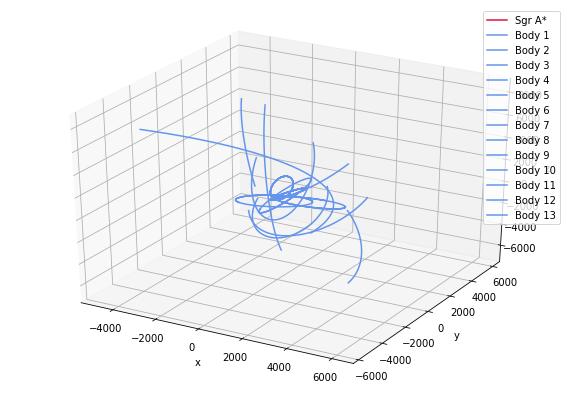

In [11]:
# Limits for the plot
xmin = np.amin(x)
xmax = np.amax(x)
ymin = np.amin(y)
ymax = np.amax(y)
zmin = np.amin(z)
zmax = np.amax(z)
rmax = 2.5*max(abs(xmin),abs(xmax),abs(ymin),abs(ymax),abs(zmin),abs(zmax))


fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.plot(q[:,0,0],q[:,0,1],q[:,0,2], color=('crimson'), label='Sgr A*')

for i in range(1,len(mass)):
  ax.plot(q[:,i,0],q[:,i,1],q[:,i,2], color=('cornflowerblue'), label=f'Body {i}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
#plt.savefig(path+'NBody-output.jpg')
plt.show()

In [12]:
energychange = (energy[n-1]-energy[0])/energy[0]
print(f'The relative change in energy is {energychange:.5E} % with a stepsize of dt = {dt:.1E}')

The relative change in energy is 2.23716E-06 % with a stepsize of dt = 1.3E-03


---
## Intearctive plot using `Plotly`

Now, we will show the orbit with an interactive plot using the function 
`plotly.graph_objects.Scatter3d()`

See documentation at https://plotly.com/python/reference/scatter3d/

and examples at https://plotly.com/python/3d-scatter-plots/ 

In [13]:
import plotly.graph_objects as go

# Orbit of Sgr A*
x1, y1, z1 = q[::2,0,0],q[::2,0,1],q[::2,0,2] # Select only even rows


fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1,
                                   mode='markers',
                                   marker=dict(
                                       size=2,
                                       color='red'),
                                   name='SgrA*'))
for i in range(1,14):
  fig.add_trace(go.Scatter3d(x=q[::2,i,0], y=q[::2,i,1], z=q[::2,i,2],
                                   mode='markers',
                                   marker=dict(
                                       size=1,
                                       color=i),
                                   name=f'Body {i}'))

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(path+'SrgA_S0_motion', q)